# Initialize notebook

In [2]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import seaborn as sn
import statistics

import sklearn as skl
from sklearn.linear_model import LinearRegression
import sklearn.pipeline as skl_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy.optimize import curve_fit

import sys
sys.path.insert(1, '../python_files')
from kitti_csv_creator import kitti_2_csv

In [3]:
# Constants
#KITTI_DATASET = '/media/javier/HDD_linux/KITTI_dataset/training/'
KITTI_DATASET = '/media/robesafe/SSD_SATA/KITTI_DATASET/'

# Create dataframe

In [4]:
# Call the fuction
kitti_2_csv(KITTI_DATASET+'label_2/', KITTI_DATASET)

In [5]:
# Open CSV file and transform to pandas dataframe
df = pd.read_csv(KITTI_DATASET+'kitti_gt.csv')
df

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
0,0,0,Pedestrian,0.0,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False
1,1,0,Car,0.0,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False
2,1,1,Cyclist,0.0,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False
3,2,0,Car,0.0,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False
4,3,0,Car,0.0,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False
34852,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False
34853,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False
34854,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False


In [5]:
train_frames, val_frames = [], []

for file in [KITTI_DATASET+'ImageSets/train.txt', KITTI_DATASET+'ImageSets/val.txt']:
    # Read txt file
    with open(file, 'r') as f:
        # Iterate over lines
        for line in f:
            # Split line by '/' and get last item
            frame = line.split('/')[-1]
            # Split filename by '.' and get first item
            frame = frame.split('.')[0]
            # Append to list
            if file == KITTI_DATASET+'ImageSets/train.txt':
                train_frames.append(int(frame))
            else:
                val_frames.append(int(frame))

In [6]:
# Create datasets for training and validation
df_train = df[df['frame'].isin(train_frames)]
df_val = df[~df['frame'].isin(train_frames)]

# Save the dataframes
df_train.to_csv(KITTI_DATASET+'kitti_train_gt.csv', index=False)
df_val.to_csv(KITTI_DATASET+'kitti_val_gt.csv', index=False)

In [7]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,...,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,...,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,...,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,...,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,...,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,...,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,...,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,...,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,...,0.16,1.54,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False


In [8]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
27998,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,...,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False
27999,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,...,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False
28000,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,...,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False
28001,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,...,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False
28002,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,...,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,...,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False
34852,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,...,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False
34853,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,...,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False
34854,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,...,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False


# Analyze dataset

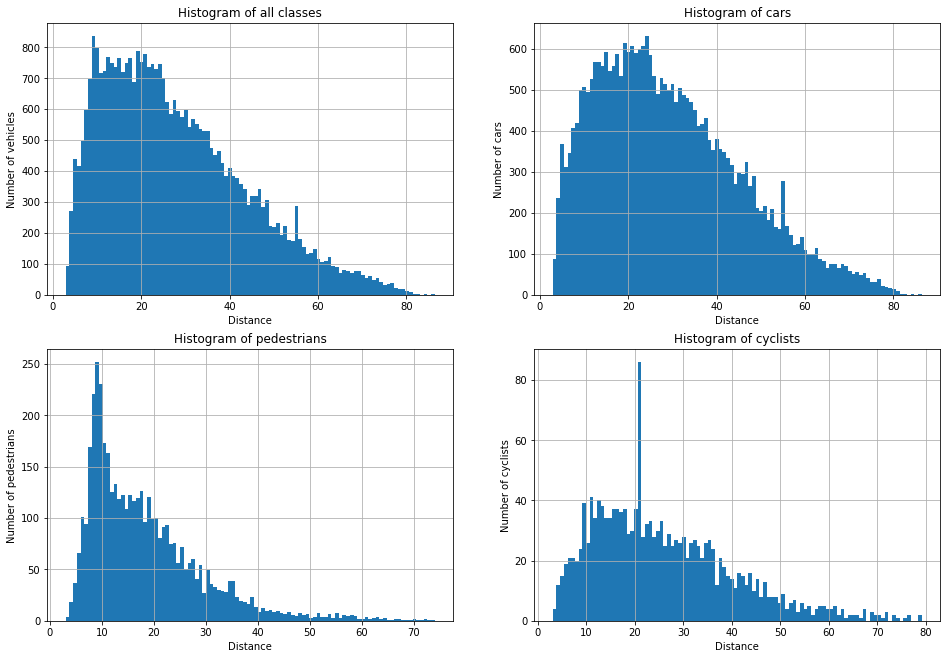

*All classes*
count    34856.000000
mean        27.809565
std         16.090348
min          2.881562
25%         15.007452
50%         24.754214
75%         37.745696
max         86.434801
Name: distance, dtype: float64

*Car*
count    28742.000000
mean        29.378774
std         16.319714
min          2.881562
25%         16.472982
50%         26.782781
75%         39.882227
max         86.434801
Name: distance, dtype: float64

*Pedestrian*
count    4487.000000
mean       18.442209
std        11.196722
min         3.032507
25%         9.866880
50%        15.713081
75%        23.513701
max        74.029991
Name: distance, dtype: float64

*Cyclist*
count    1627.000000
mean       25.922131
std        14.387199
min         3.069039
25%        14.985584
50%        22.905663
75%        34.379485
max        79.153998
Name: distance, dtype: float64


In [9]:
plt.figure(figsize=(16, 11)) 

plt.subplot(2, 2, 1)
df['distance'].hist(bins=100)
plt.title('Histogram of all classes')
plt.xlabel('Distance')
plt.ylabel('Number of vehicles')


plt.subplot(2, 2, 2)
df[df['type'] == 'Car']['distance'].hist(bins=100)
plt.title('Histogram of cars')
plt.xlabel('Distance')
plt.ylabel('Number of cars')


plt.subplot(2, 2, 3)
df[df['type'] == 'Pedestrian']['distance'].hist(bins=100)
plt.title('Histogram of pedestrians')
plt.xlabel('Distance')
plt.ylabel('Number of pedestrians')


plt.subplot(2, 2, 4)
df[df['type'] == 'Cyclist']['distance'].hist(bins=100)
plt.title('Histogram of cyclists')
plt.xlabel('Distance')
plt.ylabel('Number of cyclists')
plt.show()

print('*All classes*')
print(df['distance'].describe())
print()
print('*Car*')
print(df[df['type'] == 'Car']['distance'].describe())
print()
print('*Pedestrian*')
print(df[df['type'] == 'Pedestrian']['distance'].describe())
print()
print('*Cyclist*')
print(df[df['type'] == 'Cyclist']['distance'].describe())

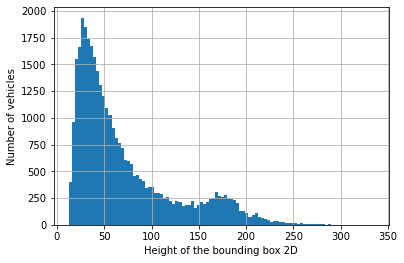

count    34856.000000
mean        71.464068
std         52.739822
min         12.670000
25%         32.670000
50%         51.730000
75%         93.280000
max        334.530000
Name: height_image, dtype: float64


In [10]:
df['height_image'].hist(bins=100)
plt.xlabel('Height of the bounding box 2D')
plt.ylabel('Number of vehicles')
plt.show()

print(df['height_image'].describe())

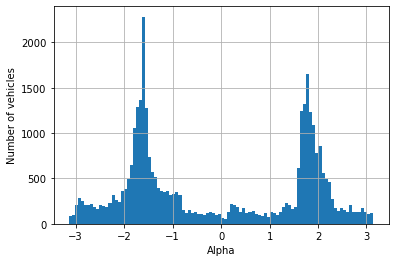

count    34856.000000
mean        -0.088102
std          1.796026
min         -3.140000
25%         -1.660000
50%         -0.775000
75%          1.780000
max          3.140000
Name: alpha, dtype: float64


In [11]:
df['alpha'].hist(bins=100)
plt.xlabel('Alpha')
plt.ylabel('Number of vehicles')
plt.show()

print(df['alpha'].describe())

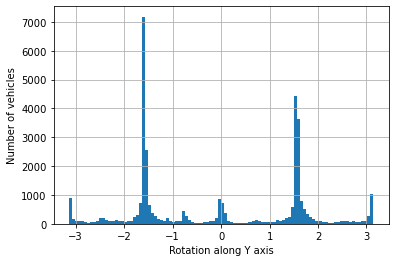

count    34856.000000
mean        -0.078953
std          1.727295
min         -3.140000
25%         -1.580000
50%         -0.180000
75%          1.570000
max          3.140000
Name: ry, dtype: float64


In [12]:
df['ry'].hist(bins=100)
plt.xlabel('Rotation along Y axis')
plt.ylabel('Number of vehicles')
plt.show()

print(df['ry'].describe())

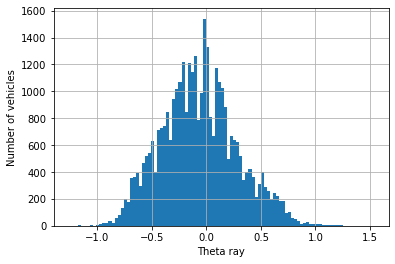

count    34856.000000
mean       611.035945
std        272.605630
min         14.710000
25%        431.267500
50%        572.430000
75%        759.267500
max       1241.000000
Name: right, dtype: float64


In [13]:
df['theta_ray'].hist(bins=100)
plt.xlabel('Theta ray')
plt.ylabel('Number of vehicles')
plt.show()

# print(df['theta_ray'].describe())
print(df['right'].describe())

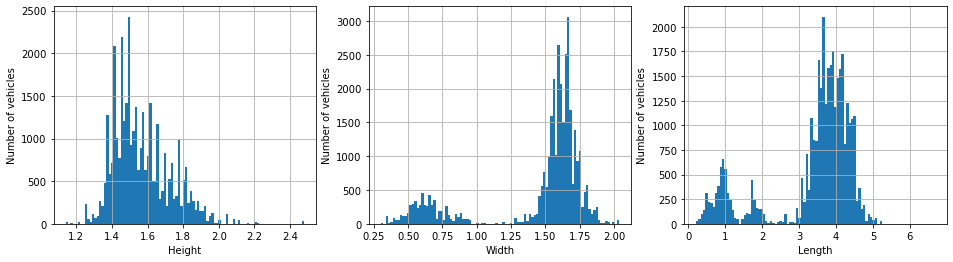

*Car*
count    28742.000000
mean         1.526083
std          0.136697
min          1.140000
25%          1.430000
50%          1.500000
75%          1.590000
max          2.480000
Name: height, dtype: float64
count    28742.000000
mean         1.628590
std          0.102164
min          1.140000
25%          1.570000
50%          1.630000
75%          1.680000
max          2.040000
Name: width, dtype: float64
count    28742.000000
mean         3.883954
std          0.425924
min          2.190000
25%          3.590000
50%          3.880000
75%          4.190000
max          6.670000
Name: length, dtype: float64

*Pedestrian*
count    4487.000000
mean        1.760706
std         0.113263
min         1.140000
25%         1.690000
50%         1.770000
75%         1.840000
max         2.010000
Name: height, dtype: float64
count    4487.000000
mean        0.660189
std         0.142667
min         0.300000
25%         0.550000
50%         0.650000
75%         0.750000
max         1.200000
N

In [14]:
plt.figure(figsize=(16, 4))

df_car = df[df['type'] == 'Car']
df_pedestrian = df[df['type'] == 'Pedestrian']
df_cyclist = df[df['type'] == 'Cyclist']

plt.subplot(1, 3, 1)
df['height'].hist(bins=100)
plt.xlabel('Height')
plt.ylabel('Number of vehicles')

plt.subplot(1, 3, 2)
df['width'].hist(bins=100)
plt.xlabel('Width')
plt.ylabel('Number of vehicles')

plt.subplot(1, 3, 3)
df['length'].hist(bins=100)
plt.xlabel('Length')
plt.ylabel('Number of vehicles')

plt.show()

print('*Car*')
print(df_car['height'].describe())
print(df_car['width'].describe())
print(df_car['length'].describe())
print()
print('*Pedestrian*')
print(df_pedestrian['height'].describe())
print(df_pedestrian['width'].describe())
print(df_pedestrian['length'].describe())
print()
print('*Cyclist*')
print(df_cyclist['height'].describe())
print(df_cyclist['width'].describe())
print(df_cyclist['length'].describe())

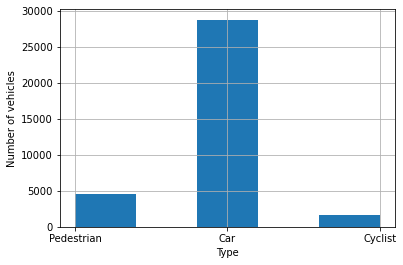

In [15]:
df['type'].hist(bins=5)
plt.xlabel('Type')
plt.ylabel('Number of vehicles')
plt.show()

In [16]:
print('Incomplete 2D horizontal rows: ' + str(len(df[df['incomplete_2d_horizontal'] == True])))
print('Incomplete 2D bottom rows: ' + str(len(df[df['incomplete_2d_horizontal'] == True])))
print('Incomplete 2D horizontal and bottom rows: ' + str(len(df[(df['incomplete_2d_horizontal'] == True) &
                                                                (df['incomplete_2d_horizontal'] == True)])))

Incomplete 2D horizontal rows: 3765
Incomplete 2D bottom rows: 3765
Incomplete 2D horizontal and bottom rows: 3765


# Statistical analysis

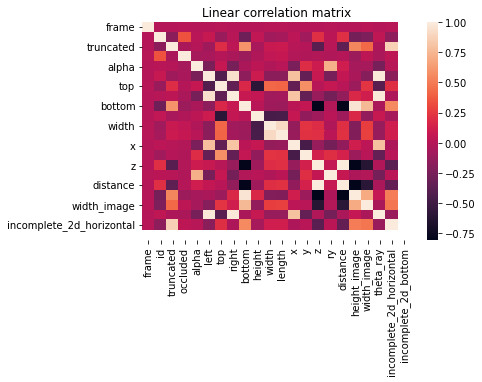

In [17]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=False)
plt.title('Linear correlation matrix')
plt.show()

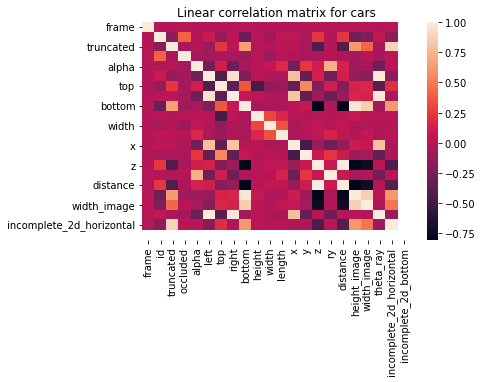

In [18]:
corrMatrix = df[df['type'] == 'Car'].corr()
sn.heatmap(corrMatrix, annot=False)
plt.title('Linear correlation matrix for cars')
plt.show()

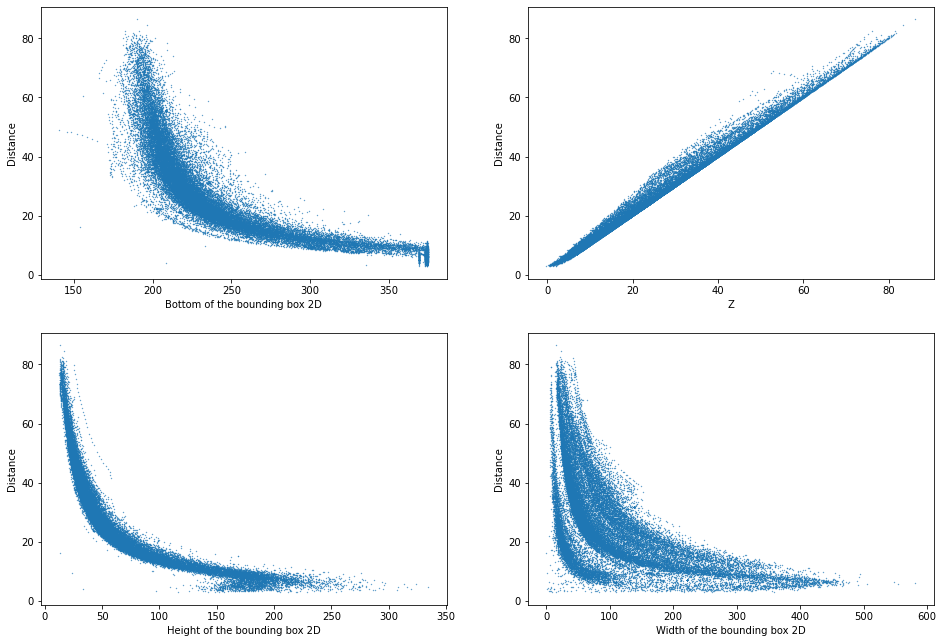

In [19]:
plt.figure(figsize=(16, 11))

Y = df['distance'].values.reshape(-1, 1)

plt.subplot(2, 2, 1)
X = df['bottom'].values.reshape(-1, 1)
plt.scatter(X, Y, s=0.1)
plt.ylabel('Distance')
plt.xlabel('Bottom of the bounding box 2D')

plt.subplot(2, 2, 2)
X = df['z'].values.reshape(-1, 1)
plt.scatter(X, Y, s=0.1)
plt.ylabel('Distance')
plt.xlabel('Z')

plt.subplot(2, 2, 3)
X = df['height_image'].values.reshape(-1, 1)
plt.scatter(X, Y, s=0.1)
plt.ylabel('Distance')
plt.xlabel('Height of the bounding box 2D')

plt.subplot(2, 2, 4)
X = df['width_image'].values.reshape(-1, 1)
plt.scatter(X, Y, s=0.1)
plt.ylabel('Distance')
plt.xlabel('Width of the bounding box 2D')

plt.show()

## Distance regression method

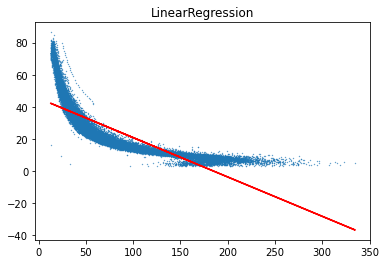

In [20]:
Y = df['distance'].values.reshape(-1, 1)
X = df['height_image'].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y, s=0.1)
plt.plot(X, Y_pred, color='red')
plt.title('LinearRegression')

plt.show()

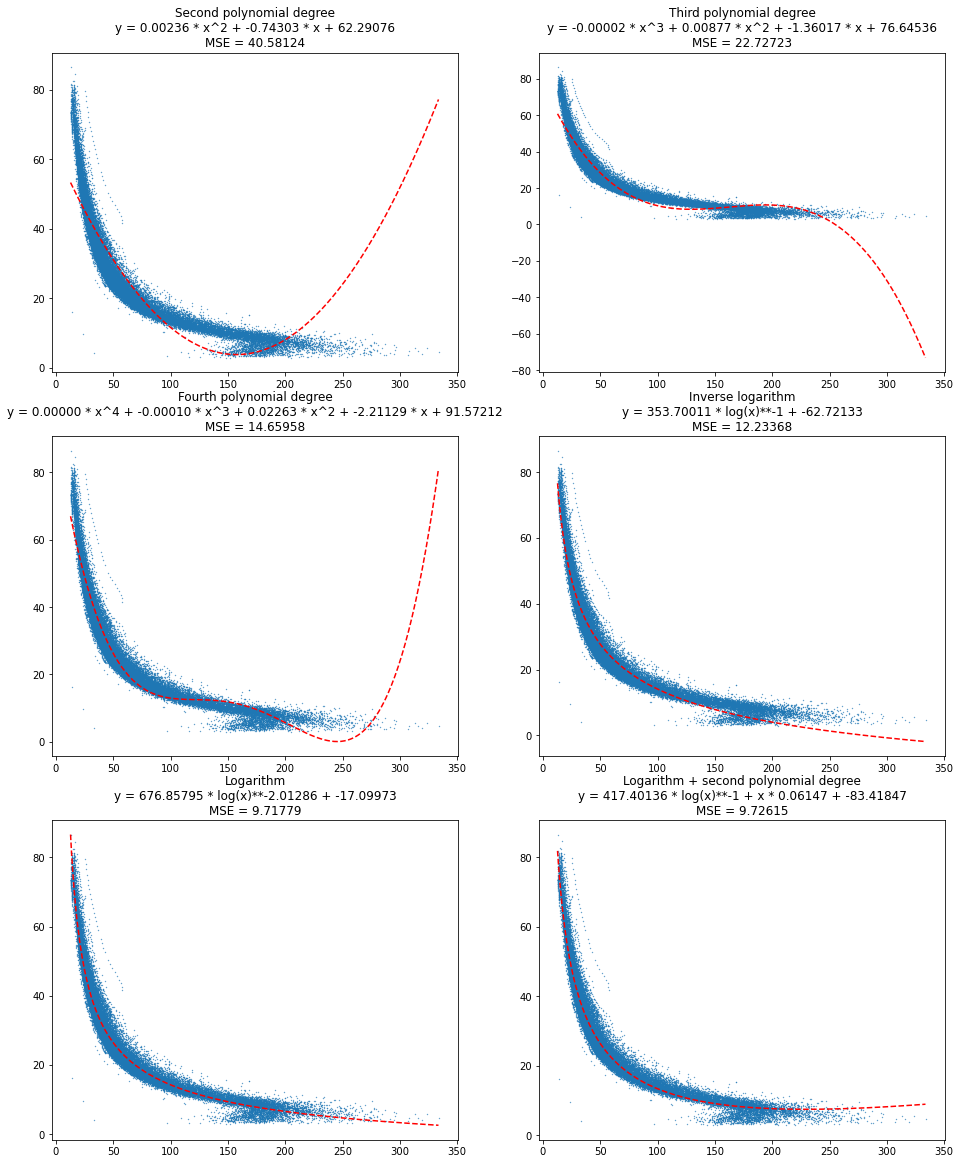

In [21]:
plt.figure(figsize=(16, 20))

Y = df['distance'].values
X = df['height_image'].values

def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_4f(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def objective_log_1f(x, a, b):
    return a * np.log(x)**-1 + b 

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

def objective_log_1_f(x, a, b, c):
    return a * np.log(x)**-1 + b * x + c 

plt.subplot(3, 2, 1)
popt, _ = curve_fit(objective_2f, X, Y, maxfev = 1000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_2f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_2f(X, a, b, c)
mse = mean_squared_error(Y, Y_pred)
plt.title('Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.subplot(3, 2, 2)
popt, _ = curve_fit(objective_3f, X, Y, maxfev = 1000)
a, b, c, d = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_3f(X_line, a, b, c, d)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_3f(X, a, b, c, d)
mse = mean_squared_error(Y, Y_pred)
plt.title('Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, d, mse))

plt.subplot(3, 2, 3)
popt, _ = curve_fit(objective_4f, X, Y, maxfev = 1000)
a, b, c, d, e = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_4f(X_line, a, b, c, d, e)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_4f(X, a, b, c, d, e)
mse = mean_squared_error(Y, Y_pred)
plt.title('Fourth polynomial degree\ny = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, d, e, mse))

plt.subplot(3, 2, 4)
popt, _ = curve_fit(objective_log_1f, X, Y, maxfev = 1000)
a, b = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1f(X_line, a, b)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_1f(X, a, b)
mse = mean_squared_error(Y, Y_pred)
plt.title('Inverse logarithm\ny = %.5f * log(x)**-1 + %.5f\nMSE = %.5f' % (a, b, mse))

plt.subplot(3, 2, 5)
popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_f(X, a, b, c)
mse = mean_squared_error(Y, Y_pred)
plt.title('Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.subplot(3, 2, 6)
popt, _ = curve_fit(objective_log_1_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_1_f(X, a, b, c)
mse = mean_squared_error(Y, Y_pred)
plt.title('Logarithm + second polynomial degree\ny = %.5f * log(x)**-1 + x * %.5f + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.show()

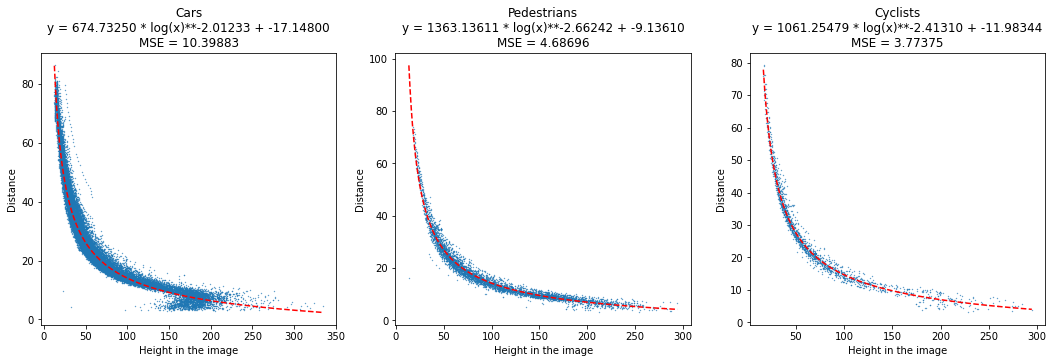

In [22]:
plt.figure(figsize=(18, 5))

df_car = df[df['type'] == 'Car']
df_pedestrian = df[df['type'] == 'Pedestrian']
df_cyclist = df[df['type'] == 'Cyclist']

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

dfs = [df_car, df_pedestrian, df_cyclist]
titles = ['Cars', 'Pedestrians', 'Cyclists']

for i in range(3):
    plt.subplot(1, 3, i+1)
    X = dfs[i]['height_image']
    Y = dfs[i]['distance']
    popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 1000000)
    a, b, c = popt
    plt.scatter(X, Y, s=0.1)
    X_line = np.arange(min(X), max(X), 0.1)
    Y_line = objective_log_f(X_line, a, b, c)
    plt.plot(X_line, Y_line, '--', color='red')
    plt.ylabel('Distance')
    plt.xlabel('Height in the image')
    Y_pred = objective_log_f(X, a, b, c)
    mse = mean_squared_error(Y, Y_pred)
    plt.title(titles[i]+str('\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse)))

plt.show()

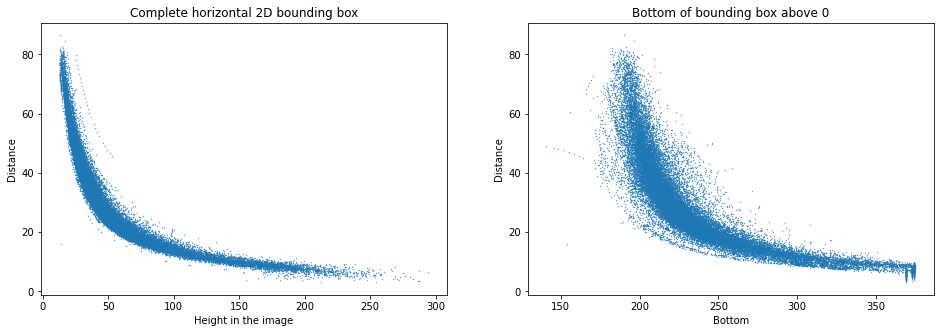

*Incomplete horizontal 2D bounding box*
count     34856
unique        2
top       False
freq      31091
Name: incomplete_2d_horizontal, dtype: object

*Bottom of bounding box above 0*
count     34856
unique        1
top       False
freq      34856
Name: incomplete_2d_bottom, dtype: object



In [23]:
plt.figure(figsize=(16, 5))

df_complete_2d_horizontal = df[df['incomplete_2d_horizontal'] == False]
df_complete_2d_bottom = df[df['incomplete_2d_bottom'] == False]

plt.subplot(1, 2, 1)
Y = df_complete_2d_horizontal['distance'].values
X = df_complete_2d_horizontal['height_image'].values
plt.scatter(X, Y, s=0.1)
plt.title('Complete horizontal 2D bounding box')
plt.xlabel('Height in the image')
plt.ylabel('Distance')

plt.subplot(1, 2, 2)
Y = df_complete_2d_horizontal['distance'].values
X = df_complete_2d_horizontal['bottom'].values
plt.scatter(X, Y, s=0.1)
plt.title('Bottom of bounding box above 0')
plt.xlabel('Bottom')
plt.ylabel('Distance')

plt.show()

print('*Incomplete horizontal 2D bounding box*')
print(df['incomplete_2d_horizontal'].describe())
print()
print('*Bottom of bounding box above 0*')
print(df['incomplete_2d_bottom'].describe())
print()

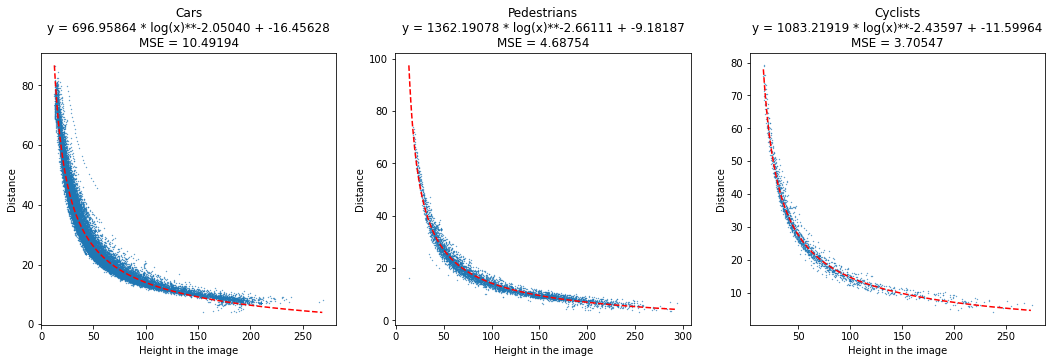

In [24]:
plt.figure(figsize=(18, 5))

df_car = df[(df['type'] == 'Car') & (df['incomplete_2d_horizontal'] == False)]
df_pedestrian = df[(df['type'] == 'Pedestrian') & (df['incomplete_2d_horizontal'] == False)]
df_cyclist = df[(df['type'] == 'Cyclist') & (df['incomplete_2d_horizontal'] == False)]

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

dfs = [df_car, df_pedestrian, df_cyclist]
titles = ['Cars', 'Pedestrians', 'Cyclists']

for i in range(3):
    plt.subplot(1, 3, i+1)
    X = dfs[i]['height_image']
    Y = dfs[i]['distance']
    popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 1000000)
    a, b, c = popt
    plt.scatter(X, Y, s=0.1)
    X_line = np.arange(min(X), max(X), 1)
    Y_line = objective_log_f(X_line, a, b, c)
    plt.plot(X_line, Y_line, '--', color='red')
    plt.ylabel('Distance')
    plt.xlabel('Height in the image')
    Y_pred = objective_log_f(X, a, b, c)
    mse = mean_squared_error(Y, Y_pred)
    plt.title(titles[i]+str('\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse)))

plt.show()

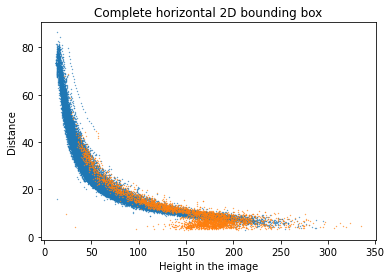

In [25]:
df_incomplete_2d_horizontal = df[df['incomplete_2d_horizontal'] == True]
df_complete_2d_horizontal = df[df['incomplete_2d_horizontal'] == False]

Y = df_complete_2d_horizontal['distance'].values
X = df_complete_2d_horizontal['height_image'].values
plt.scatter(X, Y, s=0.1)
Y = df_incomplete_2d_horizontal['distance'].values
X = df_incomplete_2d_horizontal['height_image'].values
plt.scatter(X, Y, s=0.1)
plt.title('Complete horizontal 2D bounding box')
plt.xlabel('Height in the image')
plt.ylabel('Distance')

plt.show()

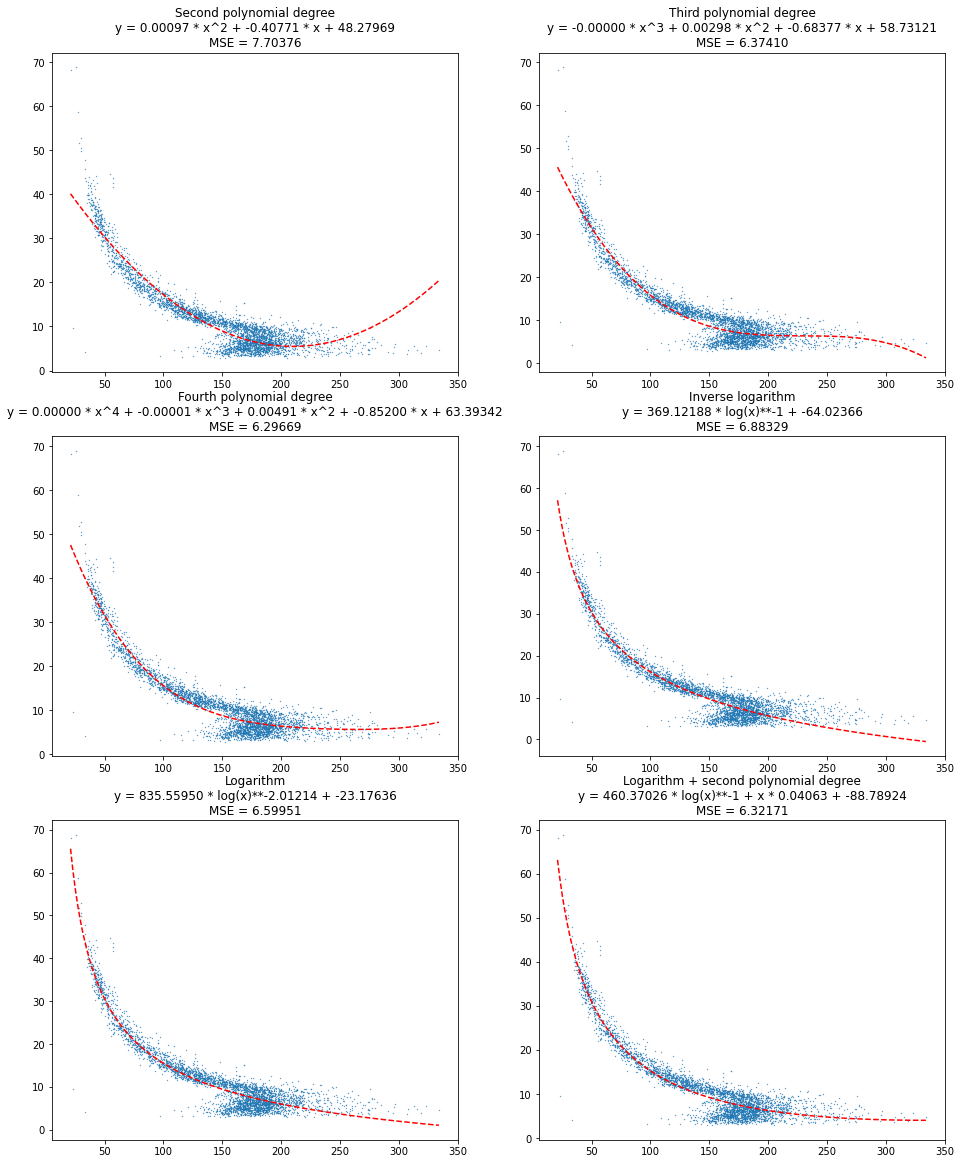

In [26]:
plt.figure(figsize=(16, 20))

df_incomplete_2d_horizontal = df[df['incomplete_2d_horizontal'] == True]

Y = df_incomplete_2d_horizontal['distance'].values
X = df_incomplete_2d_horizontal['height_image'].values

def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_4f(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def objective_log_1f(x, a, b):
    return a * np.log(x)**-1 + b 

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

def objective_log_1_f(x, a, b, c):
    return a * np.log(x)**-1 + b * x + c 

plt.subplot(3, 2, 1)
popt, _ = curve_fit(objective_2f, X, Y, maxfev = 1000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_2f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_2f(X, a, b, c)
mse = mean_squared_error(Y, Y_pred)
plt.title('Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.subplot(3, 2, 2)
popt, _ = curve_fit(objective_3f, X, Y, maxfev = 1000)
a, b, c, d = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_3f(X_line, a, b, c, d)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_3f(X, a, b, c, d)
mse = mean_squared_error(Y, Y_pred)
plt.title('Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, d, mse))

plt.subplot(3, 2, 3)
popt, _ = curve_fit(objective_4f, X, Y, maxfev = 1000)
a, b, c, d, e = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_4f(X_line, a, b, c, d, e)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_4f(X, a, b, c, d, e)
mse = mean_squared_error(Y, Y_pred)
plt.title('Fourth polynomial degree\ny = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, d, e, mse))

plt.subplot(3, 2, 4)
popt, _ = curve_fit(objective_log_1f, X, Y, maxfev = 1000)
a, b = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1f(X_line, a, b)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_1f(X, a, b)
mse = mean_squared_error(Y, Y_pred)
plt.title('Inverse logarithm\ny = %.5f * log(x)**-1 + %.5f\nMSE = %.5f' % (a, b, mse))

plt.subplot(3, 2, 5)
popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_f(X, a, b, c)
mse = mean_squared_error(Y, Y_pred)
plt.title('Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.subplot(3, 2, 6)
popt, _ = curve_fit(objective_log_1_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_1_f(X, a, b, c)
mse = mean_squared_error(Y, Y_pred)
plt.title('Logarithm + second polynomial degree\ny = %.5f * log(x)**-1 + x * %.5f + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.show()

### Error calculation

In [27]:
types = ['Car', 'Pedestrian', 'Cyclist']
distance_1decile = []
distance_9decile = []
height_images = []

#obtain deciles by type and batch
for i in range(len(types)):
    df_ = df[df['type'] == types[i]]
    height_images = df_['height_image'].values
    jump = 1
    height_images_percentiles_ = np.percentile(height_images, np.arange(0, 100, jump))
    distance_1decile.append([])
    distance_9decile.append([])
    height_images.append([])
    
    #percentile batch
    for j in range(len(height_images_percentiles_)-1):
        df_height_filter = df_[(df_['height_image'] > height_images_percentiles_[j]) &
                           (df_['height_image'] < height_images_percentiles_[j+1])]
        distances_ = df_height_filter['distance'].values
        height_images = df_height_filter['height_image'].values
        if(i == 0):
            distances_deciles_ = np.percentile(distances_, np.arange(0, 100, 2))
        else:
            distances_deciles_ = np.percentile(distances_, np.arange(0, 100, 5))
        height_image_median = statistics.median(height_images)
        distance_1decile[i].append(distances_deciles_[0])
        distance_9decile[i].append(distances_deciles_[len(distances_deciles_)-1])
        height_images[i].append(height_image_median)

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

def between_limits(popt_upper, popt_lower, X, Y):
    a_upper, b_upper, c_upper = popt_upper
    X_upper = objective_log_f(X, a_upper, b_upper, c_upper).values
    
    a_lower, b_lower, c_lower = popt_lower
    X_lower = objective_log_f(X, a_lower, b_lower, c_lower).values
    
    points_in_limits = (X_upper > Y.values) & (X_lower < Y.values)
    n_points = len(points_in_limits)
    n_points_limits = np.count_nonzero(points_in_limits)

    return n_points_limits / n_points * 100

#generate curve of variation between distance and height
plt.figure(figsize=(10, 22))
for i in range(len(types)):
    plt.subplot(3, 1, i+1)
    X = df[df['type'] == types[i]]['height_image']
    Y = df[df['type'] == types[i]]['distance']
    plt.scatter(X, Y, s=0.2)
    plt.scatter(height_images[i], distance_1decile[i], s=2)
    plt.scatter(height_images[i], distance_9decile[i], s=2)
    
    popt_lower, _ = curve_fit(objective_log_f, height_images[i], distance_1decile[i], maxfev = 1000000)
    a, b, c = popt_lower
    c -= 1
    popt_lower = (a, b, c)
    X_line = np.arange(15, 250, 1)
    Y_line = objective_log_f(X_line, a, b, c)
    plt.plot(X_line, Y_line, '--', color='black')
    
    popt_upper, _ = curve_fit(objective_log_f, height_images[i], distance_9decile[i], maxfev = 1000000)
    a, b, c = popt_upper
    c += 1
    popt_upper = (a, b, c)
    X_line = np.arange(15, 250, 1)
    Y_line = objective_log_f(X_line, a, b, c)
    plt.plot(X_line, Y_line, '--', color='black')
    
    plt.xlabel('Height in the image')
    plt.ylabel('Distance')
    plt.title(str(types[i])+"\n"+str(between_limits(popt_upper, popt_lower, X, Y))+"%")
    plt.xlim([0,350])
    plt.ylim([0,90])
    
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'append'